# Finite-Length Capacity of the Binary-Input AWGN (BI-AWGN) Channel

This code is provided as supplementary material of the lecture Channel Coding 2 - Advanced Methods.

This code illustrates
* Calculating the finite-length capacity of the binary input AWGN channel using numerical integration and the normal approximation
* Illustrating the finite-length capacity for different code lengths

In [1]:
import numpy as np
import scipy.integrate as integrate
from scipy.stats import norm
import matplotlib
import matplotlib.pyplot as plt

In [2]:
# plotting options 
font = {'size'   : 20}
plt.rc('font', **font)
plt.rc('text', usetex=matplotlib.checkdep_usetex(True))

matplotlib.rc('figure', figsize=(18, 6) )

Conditional pdf $f_{Y|X}(y|x)$ for a channel with noise variance (per dimension) $\sigma_n^2$. This is merely the Gaussian pdf with mean $x$ and variance $\sigma_n^2$

In [3]:
def f_YgivenX(y,x,sigman):
    return np.exp(-((y-x)**2)/(2*sigman**2))/np.sqrt(2*np.pi)/sigman

Output pdf $f_Y(y) = \frac12[f_{Y|X}(y|X=+1)+f_{Y|X}(y|X=-1)]$

In [4]:
def f_Y(y,sigman):
    return 0.5*(f_YgivenX(y,+1,sigman)+f_YgivenX(y,-1,sigman))

This is the function we like to integrate, $f_Y(y)\cdot\log_2(f_Y(y))$. We need to take special care of the case when the input is 0, as we defined $0\cdot\log_2(0)=0$, which is usually treated as "nan"

In [5]:
def integrand(y, sigman):
    value = f_Y(y,sigman)
    if value < 1e-20:
        return_value = 0
    else:
        return_value = value * np.log2(value)
    
    return return_value

Compute the capacity using numerical integration. We have
\begin{equation*}
C_{\text{BI-AWGN}} = -\int_{-\infty}^\infty f_Y(y)\log_2(f_Y(y))\mathrm{d}y - \frac12\log_2(2\pi e\sigma_n^2)
\end{equation*}

In [6]:
def C_BIAWGN(sigman):
    # numerical integration of the h(Y) part
    integral = integrate.quad(integrand, -np.inf, np.inf, args=(sigman))[0]
    # take into account h(Y|X)
    return -integral - 0.5*np.log2(2*np.pi*np.exp(1)*sigman**2)

Compute the dispersion of the BI-AWGN channel, which is given by (see, e.g., [1]). This is a 
\begin{equation*}
V = \frac{1}{\pi}\int_{-\infty}^{\infty}e^{-z^2}\left(1-\log_2\left(1+\exp\left(-\frac{2}{\sigma_n^2}+\frac{2\sqrt{2}}{\sigma_n}z\right)\right)-C\right)^2\mathrm{d}z
\end{equation*}
where $C$ is the capacity of the BI-AWGN channel. The integral can be computed numerically or using the Gauss-Hermite quadrature (https://en.wikipedia.org/wiki/Gauss%E2%80%93Hermite_quadrature). Both versions are given below.

[1] M. Coşkun, G. Durisi, T. Jerkovits, G. Liva, W. Ryan, B. Stein, F. Steiner, "Efficient error-correcting codes in the short blocklength regime", _Physical Communication,_ pp. 66-79, 34, 2019, preprint available online https://arxiv.org/abs/1812.08562

In [7]:
def V_integrand(z, C, sigman):
    sigmanq = np.square(sigman)
    m1 = np.square(1 - np.log2(1 + np.exp(-2/sigmanq + 2*np.sqrt(2)*z/sigman)) - C)
    m2 = np.exp(-np.square(z))
    if np.isinf(m1) or np.isinf(m2):
        value = 0
    else:    
        value = m1*m2
    return value

In [8]:
# compute the dispersion using numerical integration
def V_BIAWGN(C, sigman):
    integral = integrate.quad(V_integrand, -np.inf, np.inf, args=(C,sigman))[0]
    return integral/np.sqrt(np.pi)


# Alternative implementation using Gauss-Hermite Quadrature
x_GH, w_GH = np.polynomial.hermite.hermgauss(40)
def V_BIAWGN_GH(C, sigman):    
    integral = sum(w_GH * [np.square(1-np.log2(1 + np.exp(-2/np.square(sigman) + 2*np.sqrt(2)*xi/sigman)) - C) for xi in x_GH])
    return integral / np.sqrt(np.pi)

The finite-length capacity for the BI-AWGN channel is given by
\begin{equation*}
r = \frac{\log_2(M)}{n} \approx C - \sqrt{\frac{V}{n}}Q^{-1}(P_e) + \frac{\log_2(n)}{2n}
\end{equation*}
We can solve this equation for $P_e$, which gives
\begin{equation*}
P_e \approx Q\left(\frac{n(C-r) + \frac{1}{2}\log_2(n)}{\sqrt{Vn}}\right)
\end{equation*}
For a given channel (i.e., a given $E_s/N_0$ or its equivalent noise variance $\sigma_n^2$), we can compute the capacity $C$ and the dispersion $V$ and then use it to get an estimate of what error rate an ideal code with an idea decoder could achieve. Note that this is only an estimate and we do not know the exact value. However, we can compute upper and lower bounds, which are relatively close to the approximation (beyond the scope of this lecture, see, e.g., [1] for details)

In [9]:
def get_Pe_finite_length(n, r, sigman):
    # compute capacity
    C = C_BIAWGN(sigman)
    
    # compute dispersion
    V = V_BIAWGN_GH(C, sigman)
    
    # Q-function is "norm.sf" (survival function)
    return norm.sf((n*(C-r) + 0.5*np.log2(n))/np.sqrt(n*V))

Show finite length capacity estimates for some codes of different lengths $n$

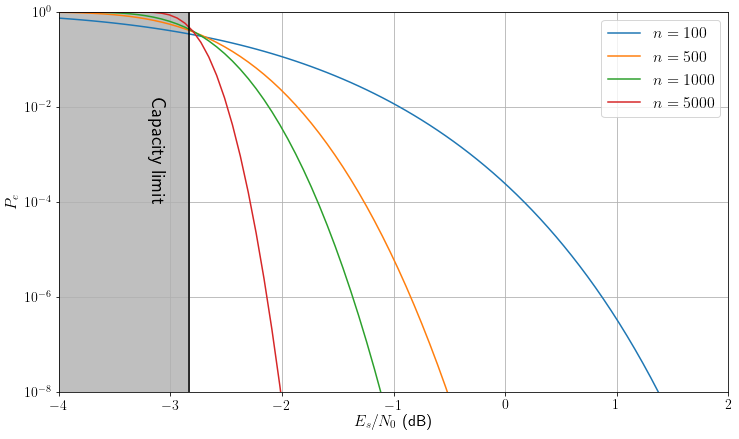

In [10]:
esno_dB_range = np.linspace(-4,3,100)
esno_lin_range = [10**(esno_db/10) for esno_db in esno_dB_range]

# compute sigma_n
sigman_range = [np.sqrt(1/2/esno_lin) for esno_lin in esno_lin_range]

capacity_BIAWGN = [C_BIAWGN(sigman) for sigman in sigman_range]

Pe_BIAWGN_r12_n100 = [get_Pe_finite_length(100, 0.5, sigman) for sigman in sigman_range]
Pe_BIAWGN_r12_n500 = [get_Pe_finite_length(500, 0.5, sigman) for sigman in sigman_range]
Pe_BIAWGN_r12_n1000 = [get_Pe_finite_length(1000, 0.5, sigman) for sigman in sigman_range]
Pe_BIAWGN_r12_n5000 = [get_Pe_finite_length(5000, 0.5, sigman) for sigman in sigman_range]

fig = plt.figure(1,figsize=(12,7))
plt.semilogy(esno_dB_range, Pe_BIAWGN_r12_n100)
plt.semilogy(esno_dB_range, Pe_BIAWGN_r12_n500)
plt.semilogy(esno_dB_range, Pe_BIAWGN_r12_n1000)
plt.semilogy(esno_dB_range, Pe_BIAWGN_r12_n5000)
plt.axvspan(-4, -2.83, alpha=0.5, color='gray')
plt.axvline(x=-2.83, color='k')
plt.ylim((1e-8,1))
plt.xlim((-4,2))
plt.xlabel('$E_s/N_0$ (dB)', fontsize=16)
plt.ylabel('$P_e$', fontsize=16)
plt.legend(['$n = 100$', '$n=500$','$n=1000$', '$n=5000$'], fontsize=16)
plt.text(-3.2, 1e-4, 'Capacity limit', {'color': 'k', 'fontsize': 20, 'rotation': -90})
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(True)
#plt.savefig('BI_AWGN_Pe_R12.pdf',bbox_inches='tight')

Different representation, for a given channel (and here, we pick $E_s/N_0 = -2.83$ dB), show the rate the code should at most have to allow for decoding with an error rate $P_e$ (here we specify different $P_e$) if a certain length $n$ is available.

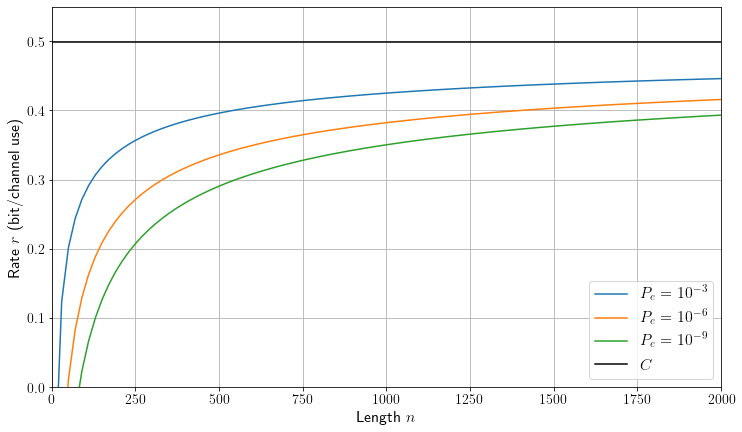

In [11]:
#specify esno
esno = -2.83


n_range = np.linspace(10,2000,100)


sigman = np.sqrt(0.5*10**(-esno/10))


C = C_BIAWGN(sigman)
V = V_BIAWGN_GH(C, sigman)

r_Pe_1em3 = [C - np.sqrt(V/n)*norm.isf(1e-3) + 0.5*np.log2(n)/n for n in n_range]
r_Pe_1em6 = [C - np.sqrt(V/n)*norm.isf(1e-6) + 0.5*np.log2(n)/n for n in n_range]
r_Pe_1em9 = [C - np.sqrt(V/n)*norm.isf(1e-9) + 0.5*np.log2(n)/n for n in n_range]

fig = plt.figure(1,figsize=(12,7))
plt.plot(n_range, r_Pe_1em3)
plt.plot(n_range, r_Pe_1em6)
plt.plot(n_range, r_Pe_1em9)
plt.axhline(y=C, color='k')
plt.ylim((0,0.55))
plt.xlim((0,2000))
plt.xlabel('Length $n$', fontsize=16)
plt.ylabel('Rate $r$ (bit/channel use)', fontsize=16)
plt.legend(['$P_e = 10^{-3}$', '$P_e = 10^{-6}$','$P_e = 10^{-9}$', '$C$'], fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(True)
#plt.savefig('BI_AWGN_r_esno_m283.pdf',bbox_inches='tight')